# Slip detection notebook
Following is a simple trial of slip detection using tactile sensors.

## Slip detection data collection description:
Slip detection data is collected by grasping an object affixed to the environment and moving the robot hand in a smooth continuous motion generated via a combination of sinusoidal waves with random amplitude and frequency. The difference between "slip" and "non-slip" is the total amplitude of the sinusoidal waves such that there is none to minimal slippage.
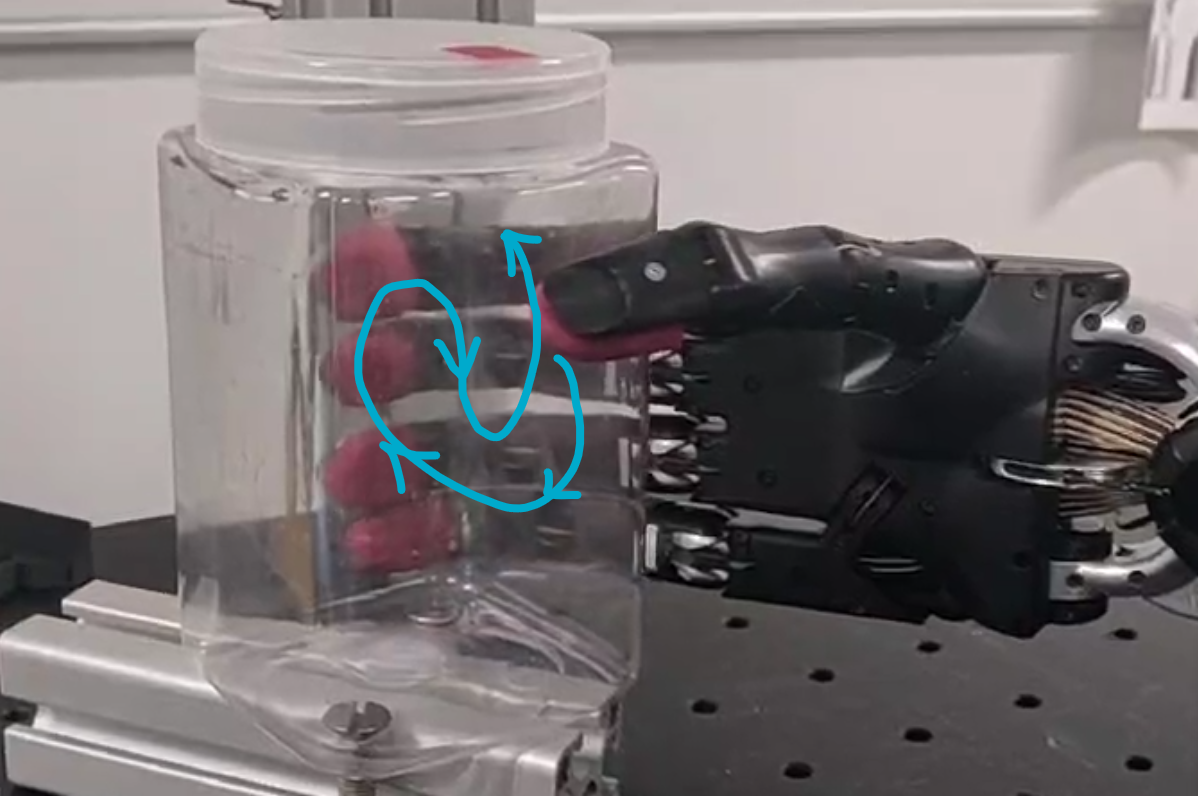




In [20]:
data_path = "G:\\datasets\\tac2Slip"
classes = ['no_slip', 'slip']
import os
import csv
import time
import numpy as np
def import_csv(file_path):
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        #skip header
        next(reader)
        data = []
        for row in reader:
            data.append([float(i) for i in row])
    data = np.array(data, dtype=np.float32)
    time = data[:, 0]
    data = data[:, 1:]
    return time, data



# ----------------------------- Import slip data ----------------------------- #
total_slip_data = []
c = 1
for file_path in os.listdir(os.path.join(data_path, classes[c])):
    if file_path.endswith('.csv'):
        time, data = import_csv(os.path.join(data_path, classes[c], file_path))
        total_slip_data.append(data)
total_slip_data = np.concatenate(total_slip_data, axis=0)
print(total_slip_data.shape)


# ---------------------------- Import no slip data --------------------------- #
total_no_slip_data = []
c = 0
for file_path in os.listdir(os.path.join(data_path, classes[c])):
    if file_path.endswith('.csv'):
        time, data = import_csv(os.path.join(data_path, classes[c], file_path))
        total_no_slip_data.append(data)
total_no_slip_data = np.concatenate(total_no_slip_data, axis=0)
print(total_no_slip_data.shape)






(59512, 255)
(49641, 255)


In [24]:
# Restructure the data columns into 5 groups of 51 corresponding to 17x3 taxels
def restructure_data(data):
    n_samples = data.shape[0]
    n_taxels = 17
    n_channels = 3
    restructured_data = np.zeros((n_samples, 5, n_taxels, n_channels), dtype=np.float32)
    for k in range(5):
        for i in range(n_taxels):
            for j in range(n_channels):
                restructured_data[:, k, i, j] = data[:, k * n_taxels * n_channels + i * n_channels + j]
    return restructured_data


restructured_slip = restructure_data(total_slip_data)
restructured_no_slip = restructure_data(total_no_slip_data)
print(restructured_slip.shape)
print(restructured_no_slip.shape)

np.set_printoptions(suppress=True, precision=4)
print(restructured_slip[0, :, :, :])

(59512, 5, 17, 3)
(49641, 5, 17, 3)
[[[ -188.   -54. -1042.]
  [  -83.   -32.  -255.]
  [  -41.     0.  -213.]
  [  -64.    36.  -939.]
  [    5.    -1.  -811.]
  [  -36.   -30.  -209.]
  [  -95.   -59.  -279.]
  [  -24.    -7.  -149.]
  [  -62.   -23.  -302.]
  [  -93.    33.  -250.]
  [ -110.     0.  -459.]
  [  -63.    26.  -268.]
  [  -89.     3.  -195.]
  [  -18.    71.  -399.]
  [  -23.     7.  -253.]
  [ -237.   -86.  -532.]
  [ -121.   -17.  -302.]]

 [[ -145.   -28.  -329.]
  [  -78.   -13.  -276.]
  [  -84.    20.  -254.]
  [ -134.   -29.  -379.]
  [  -98.   -11.  -298.]
  [  -41.    12.  -209.]
  [  -69.    -8.  -214.]
  [  -78.   -11.  -287.]
  [ -104.    -4.  -302.]
  [  -58.    22.  -234.]
  [  -76.    10.  -326.]
  [  -53.    -8.  -170.]
  [  -66.    46.  -212.]
  [  -59.    24.  -221.]
  [  -66.    19.  -249.]
  [  -89.   -17.  -323.]
  [ -109.     7.  -286.]]

 [[ -171.    -5.  -364.]
  [  -94.    -6.  -242.]
  [  -68.    26.  -236.]
  [ -157.   -18.  -412.]
  [ -123. 

In [28]:
# ----------------------------- thumb classifier ----------------------------- #
th_slip = restructured_slip[:, 0, :, :]
th_no_slip = restructured_no_slip[:, 0, :, :]
print(th_slip.shape)
print(th_no_slip.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X = np.concatenate((th_slip, th_no_slip), axis=0)
y = np.concatenate((np.ones(th_slip.shape[0]), np.zeros(th_no_slip.shape[0])), axis=0)
X = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f'Thumb classifier accuracy: {accuracy * 100:.2f}%')





(59512, 17, 3)
(49641, 17, 3)
Thumb classifier accuracy: 97.48%
(109153, 255)
(109153,)
(87322, 255)


In [39]:
# -------------------------- all fingers classifier -------------------------- #
X = np.concatenate((restructured_slip, restructured_no_slip), axis=0)
y = np.concatenate((np.ones(restructured_slip.shape[0]), np.zeros(restructured_no_slip.shape[0])), axis=0)
# X = X.reshape(X.shape[0], -1)
y = np.concatenate((np.ones((th_slip.shape[0],5)), np.zeros((th_no_slip.shape[0],5))), axis=0)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)


# ----------------------- individual_finger_classifiers ---------------------- #
print("RandomForestClassifier for individual fingers:")
fingers = ['th', 'ff', 'mf', 'rf', 'lf']
classifiers = {}
for i, finger in enumerate(fingers):
    X_finger = X[:, i,:, :].reshape(X.shape[0], -1)
    y_finger = y[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X_finger, y_finger, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    classifiers[finger] = clf
    print(f'{finger} classifier accuracy: {accuracy * 100:.2f}%')

# ----------------------------- Gradient Boosting ---------------------------- #
print("\nGradientBoostingClassifier for individual fingers:")
from sklearn.ensemble import GradientBoostingClassifier
fingers = ['th', 'ff', 'mf', 'rf', 'lf']
classifiers_gb = {}
for i, finger in enumerate(fingers):
    X_finger = X[:, i,:, :].reshape(X.shape[0], -1)
    y_finger = y[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X_finger, y_finger, test_size=0.2, random_state=42)
    clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    clf_gb.fit(X_train, y_train)
    accuracy = clf_gb.score(X_test, y_test)
    classifiers_gb[finger] = clf_gb
    print(f'{finger} classifier accuracy: {accuracy * 100:.2f}%')


(109153, 5, 17, 3)
(109153, 5)
(87322, 5, 17, 3)
RandomForestClassifier for individual fingers:
th classifier accuracy: 97.48%
ff classifier accuracy: 97.99%
mf classifier accuracy: 96.94%
rf classifier accuracy: 98.31%
lf classifier accuracy: 97.89%

GradientBoostingClassifier for individual fingers:
th classifier accuracy: 96.40%
ff classifier accuracy: 97.39%
mf classifier accuracy: 95.97%
rf classifier accuracy: 97.38%
lf classifier accuracy: 97.01%
